# 약물-단백질 상호작용

- 약물과 단백질의 상호작용 정도를 점수화한 데이터를 이용하여 상호작용을 예측하는 머신러닝 모델을 구현
- 약물과 단백질 데이터를 각각 입력으로 사용한다
    1. 약물의 특성과 단백질(타겟)의 특성을 각각 추출하는 모델 구성
    2. 추출된 특성을 **옆으로 붙인(concatenate)** 값을 만드고 이를 DTI 예측 모델 입력으로 사용한다
    3. 상호작용은 이진분류(0/1) 예측(확률) 또는 상호작용 점수 회귀 예측을 하게 된다.
- 약물 재창출 예제

- [DeepPurpose](https://deeppurpose.readthedocs.io/en/latest/notes/introduction.html) 모듈 사용
 - 약물-단백질 상호작용 예측 모델 구현 기능을 제공
 - 가상선별과 약물재창출을 위한 딥러닝 도구

In [1]:
!pip install pandas-flavor
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install DeepPurpose

  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-m36q20qt
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-m36q20qt
  Resolved https://github.com/bp-kelley/descriptastorus to commit 86eedc60546abe6f59cdbcb12025a61157ba178d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 17.7 MB/s eta 0:00:00
  Created wheel for descriptastorus: filename=descriptastorus-2.5.0.20-py3-none-any.whl size=1083427 sha256=b3f5ce8329bb565338dd50f79b7cfa2d7d64e667ad7dc56a3b560e5e72f60fae
  Stored in directory: /tmp/pip-ephem-wheel-cache-kieyyvrj/wheels/b0/91/ea/7e8b56f17611c9bebc7f08065799bd317abd64f066463e2e8a
Successfully built descriptastorus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 

# import

In [1]:
import torch
import DeepPurpose.DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
import DeepPurpose.oneliner as oneliner
import numpy as np
import pickle

%config InlineBackend.figure_format = 'retina'

# 데이터(이진분류)

In [2]:
# binary 인자를 True로 선택하면 이진 분류 레이블을 사용
X_drug, X_target, y = load_process_DAVIS('./data/', binary=True)

# 화합물 데이터 확인
print("drug : ", X_drug[:3], end="\n\n")

# 타겟 단백질 데이터 확인
print("target : ",X_target[0], end="\n\n")

# 결합 여부 확인 (0이면 결합 안함, 1이면 결합)
print("Interaction : ",y[:3], end="\n\n")

Beginning Processing...
100% [........................................................] 179878 / 179878Beginning to extract zip file...
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter
Done!
drug :  ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N'
 'CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N'
 'CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']

target :  MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQ

In [3]:
# MLP 모델을 위한 encoding 방식 지정 (입력 특성으로 1차원 벡터를 사용)
drug_encoding = 'Morgan'
target_encoding = 'AAC'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random', frac=[0.8,0.1,0.1])
train[:3]

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
Done.


,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.221, 3.33, 3.434, 4.683, 1.353, 4.475, 11.6..."
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."


# MLP 모델 사용

## 모델 정의 및 학습

In [13]:
# 모델 정의
config = generate_config(drug_encoding = drug_encoding, # encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 구조 정의
                         train_epoch = 100, # epoch 횟수
                         LR = 0.001, # 학습률 지정
                         batch_size = 256 # 배치사이즈 지정
                        )
model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (model_protein): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=8420, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)


Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69586. Total time 0.00083 hours
Validation at Epoch 1, AUROC: 0.85652 , AUPRC: 0.30333 , F1: 0.24242 , Cross-entropy Loss: 1.79858
Training at Epoch 2 iteration 0 with loss 0.12390. Total time 0.0025 hours
Validation at Epoch 2, AUROC: 0.88784 , AUPRC: 0.37282 , F1: 0.2 , Cross-entropy Loss: 1.72664
Training at Epoch 3 iteration 0 with loss 0.08781. Total time 0.00416 hours
Validation at Epoch 3, AUROC: 0.88433 , AUPRC: 0.35929 , F1: 0.17877 , Cross-entropy Loss: 1.76261
Training at Epoch 4 iteration 0 with loss 0.12751. Total time 0.00611 hours
Validation at Epoch 4, AUROC: 0.87652 , AUPRC: 0.38202 , F1: 0.19318 , Cross-entropy Loss: 1.70266
Training at Epoch 5 iteration 0 with loss 0.19867. Total time 0.00777 hours
Validation at Epoch 5, AUROC: 0.88357 , AUPRC: 0.42744 , F1: 0.19653 , Cross-entropy Loss: 1.66668
Training at Epoch 6 iteration 0 with loss 0.12520. Total time 0.

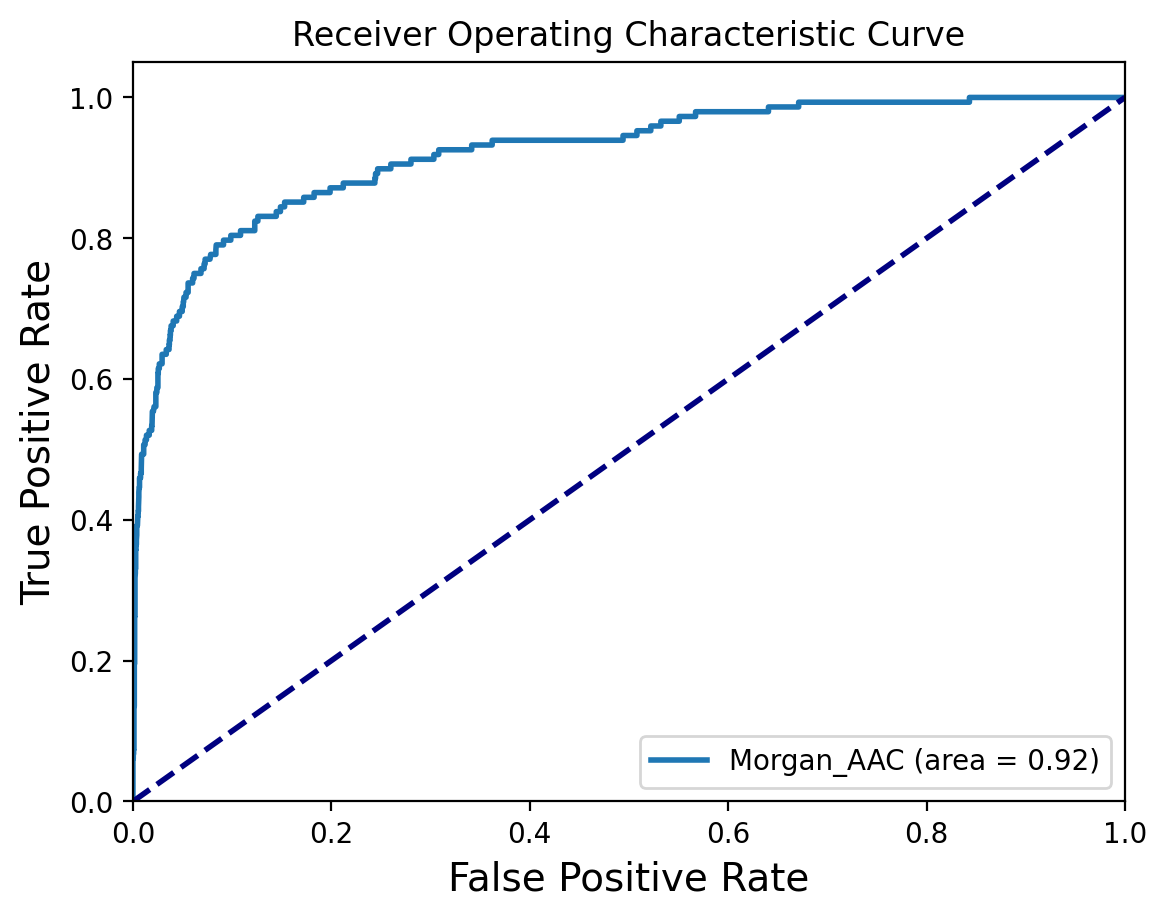

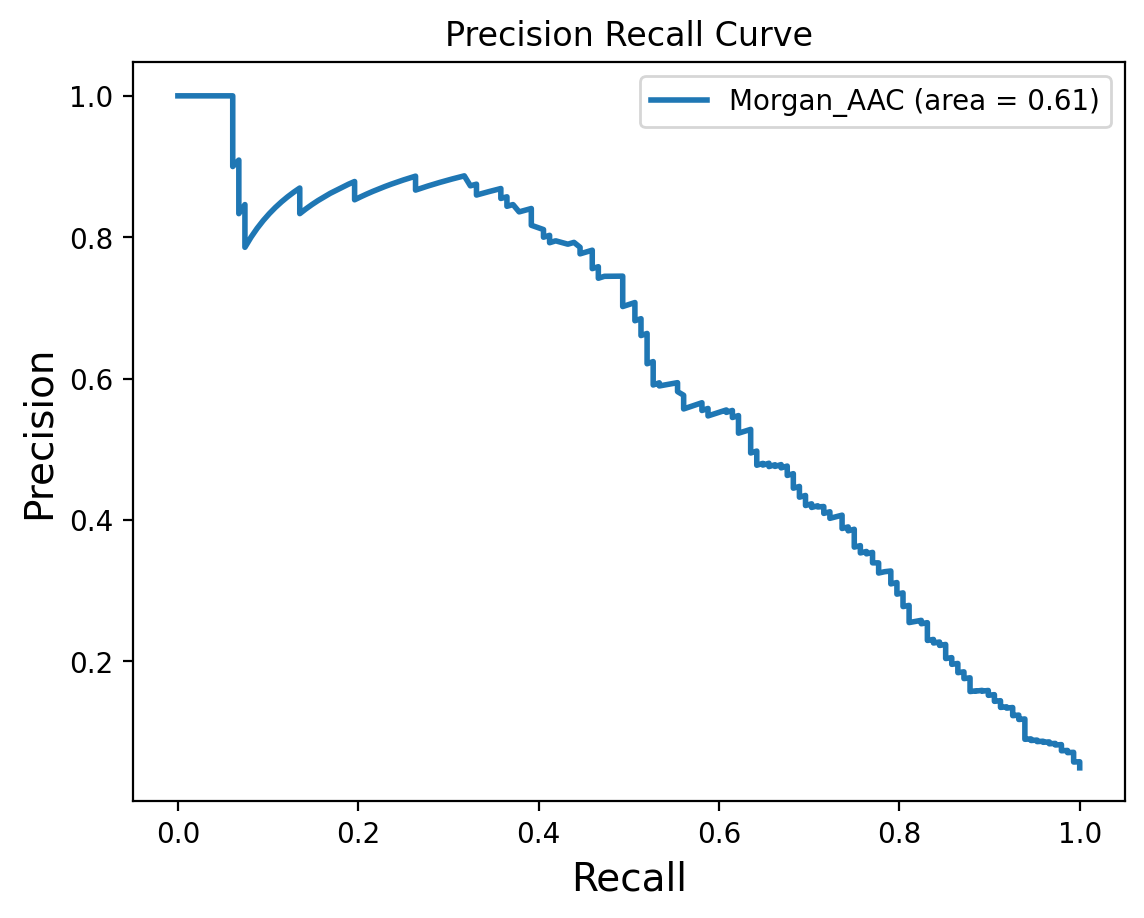

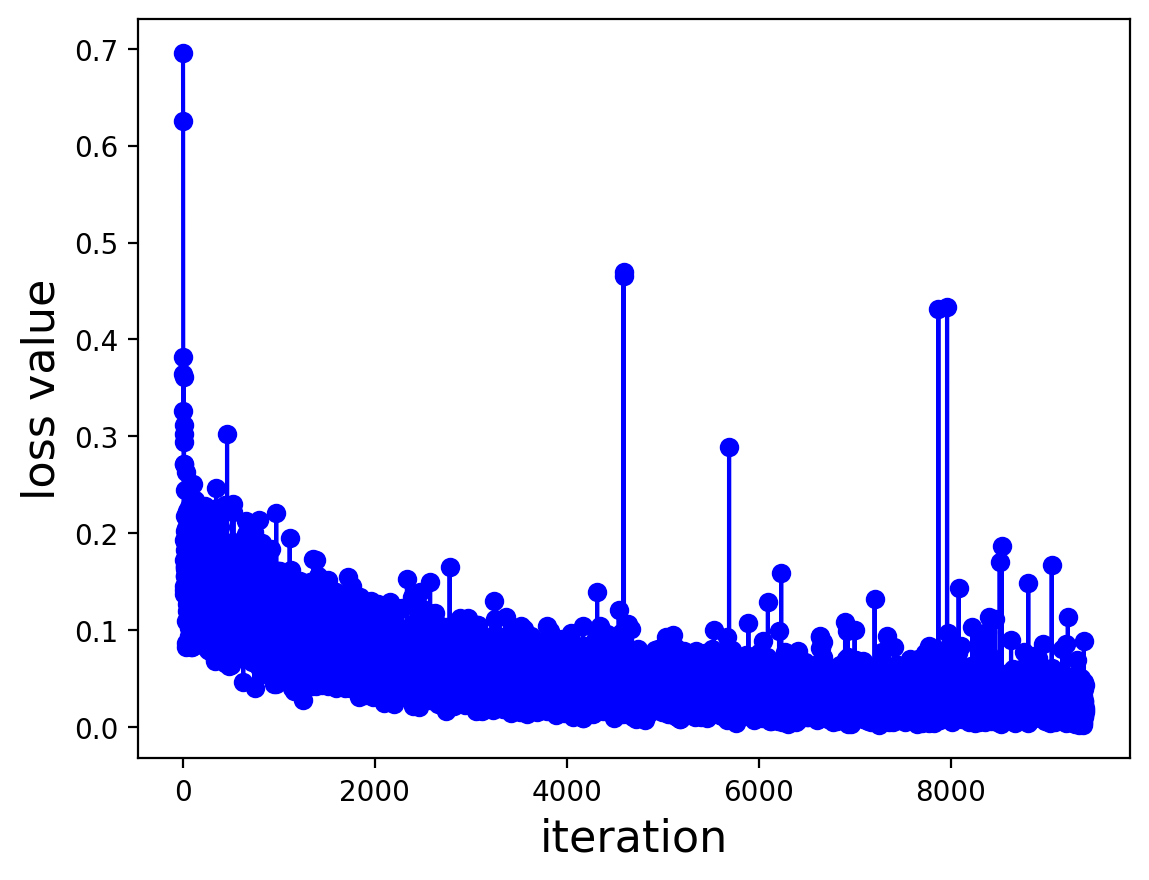

In [14]:
# 학습시간이 오래 걸린다 (11분)
model.train(train, val, test)

### 모델 저장

In [ ]:
# 모델 저장 코드 (Morgan_AAC_model 폴더가 생성되며 그 안에 모델 가중치와 모델의 설정값이 저장됨)
model.save_model('./Morgan_AAC_model')

# CNN 모델 사용

## 모델 정의 및 학습

In [ ]:
drug_encoding = 'CNN'
target_encoding = 'CNN'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.8,0.1,0.1])


config = generate_config(drug_encoding = drug_encoding,# encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 말단의 예측 레이어의 구조 정의
                         train_epoch = 100, # 모델 학습 시 반복 횟수 지정
                         LR = 0.001, # 학습률 지정
                         batch_size = 256, # 배치사이즈 지정
                         cnn_drug_filters = [32,64,96], # 약물 레이어의 cnn 필터 개수 지정
                         cnn_target_filters = [32,64,96], # 타겟 레이어의 cnn 핕터 개수 지정
                         cnn_drug_kernels = [4,6,8], # 약물 레이어의 커널 사이즈 지정
                         cnn_target_kernels = [4,8,12] # 타겟 레이어의 커널 사이즈 지정
                        )

model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.
Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_feat

In [ ]:
# CNN 모델 사용

## 모델 정의 및 학습

drug_encoding = 'CNN'
target_encoding = 'CNN'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.8,0.1,0.1])


config = generate_config(drug_encoding = drug_encoding,# encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 말단의 예측 레이어의 구조 정의
                         train_epoch = 100, # 모델 학습 시 반복 횟수 지정
                         LR = 0.001, # 학습률 지정
                         batch_size = 256, # 배치사이즈 지정
                         cnn_drug_filters = [32,64,96], # 약물 레이어의 cnn 필터 개수 지정
                         cnn_target_filters = [32,64,96], # 타겟 레이어의 cnn 핕터 개수 지정
                         cnn_drug_kernels = [4,6,8], # 약물 레이어의 커널 사이즈 지정
                         cnn_target_kernels = [4,8,12] # 타겟 레이어의 커널 사이즈 지정
                        )

model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Let's use 2 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70481. Total time 0.0 hours
Validation at Epoch 1, AUROC: 0.83996 , AUPRC: 0.27639 , F1: 0.0 , Cross-entropy Loss: 1.71200
Training at Epoch 2 iteration 0 with loss 0.18051. Total time 0.01944 hours
Validation at Epoch 2, AUROC: 0.87322 , AUPRC: 0.35533 , F1: 0.0 , Cross-entropy Loss: 1.71200
Training at Epoch 3 iteration 0 with loss 0.14139. Total time 0.03888 hours
Validation at Epoch 3, AUROC: 0.88586 , AUPRC: 0.35638 , F1: 0.03921 , Cross-entropy Loss: 1.68902
Training at Epoch 4 iteration 0 with loss 0.12764. Total time 0.05805 hours
Validation at Epoch 4, AUROC: 0.88951 , AUPRC: 0.39594 , F1: 0.22580 , Cross-entropy Loss: 1.65455
Training at Epoch 5 iteration 0 with loss 0.13224. Total time 0.0775 hours
Validation at Epoch 5, AUROC: 0.89040 , AUPRC: 0.43016 , F1: 0.31627 , Cross-entropy Loss: 1.68903
Training at Epoch 6 iteration 0 with loss 0.13688. Total time 0.09694 h

Validation at Epoch 47, AUROC: 0.95215 , AUPRC: 0.67415 , F1: 0.65427 , Cross-entropy Loss: 1.06857
Training at Epoch 48 iteration 0 with loss 0.03516. Total time 0.91111 hours
Validation at Epoch 48, AUROC: 0.94164 , AUPRC: 0.66417 , F1: 0.61003 , Cross-entropy Loss: 1.16049
Training at Epoch 49 iteration 0 with loss 0.07081. Total time 0.93083 hours
Validation at Epoch 49, AUROC: 0.94887 , AUPRC: 0.64404 , F1: 0.61832 , Cross-entropy Loss: 1.14900
Training at Epoch 50 iteration 0 with loss 0.05567. Total time 0.95027 hours
Validation at Epoch 50, AUROC: 0.94499 , AUPRC: 0.65034 , F1: 0.63082 , Cross-entropy Loss: 1.18347
Training at Epoch 51 iteration 0 with loss 0.04321. Total time 0.96972 hours
Validation at Epoch 51, AUROC: 0.94616 , AUPRC: 0.66468 , F1: 0.63197 , Cross-entropy Loss: 1.13751
Training at Epoch 52 iteration 0 with loss 0.06402. Total time 0.98888 hours
Validation at Epoch 52, AUROC: 0.94035 , AUPRC: 0.66715 , F1: 0.62093 , Cross-entropy Loss: 1.20645
Training at Epo

Training at Epoch 94 iteration 0 with loss 0.03614. Total time 1.80138 hours
Validation at Epoch 94, AUROC: 0.94570 , AUPRC: 0.66050 , F1: 0.58365 , Cross-entropy Loss: 1.22943
Training at Epoch 95 iteration 0 with loss 0.02660. Total time 1.82083 hours
Validation at Epoch 95, AUROC: 0.93529 , AUPRC: 0.62787 , F1: 0.60674 , Cross-entropy Loss: 1.20645
Training at Epoch 96 iteration 0 with loss 0.01897. Total time 1.84027 hours
Validation at Epoch 96, AUROC: 0.93539 , AUPRC: 0.60262 , F1: 0.59854 , Cross-entropy Loss: 1.26390
Training at Epoch 97 iteration 0 with loss 0.01748. Total time 1.85944 hours
Validation at Epoch 97, AUROC: 0.93784 , AUPRC: 0.61582 , F1: 0.56589 , Cross-entropy Loss: 1.28688
Training at Epoch 98 iteration 0 with loss 0.02162. Total time 1.87888 hours
Validation at Epoch 98, AUROC: 0.93967 , AUPRC: 0.62163 , F1: 0.60240 , Cross-entropy Loss: 1.13751
Training at Epoch 99 iteration 0 with loss 0.03449. Total time 1.89805 hours
Validation at Epoch 99, AUROC: 0.93507

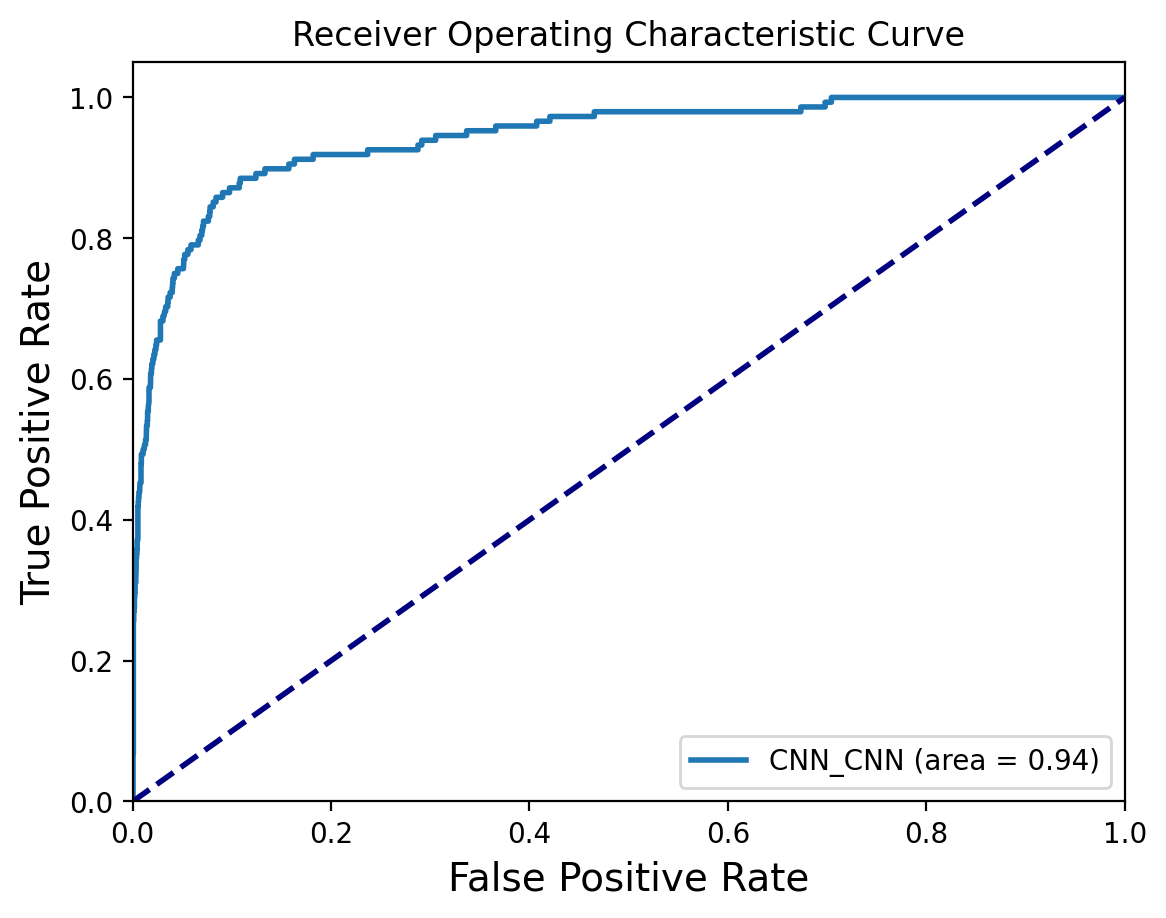

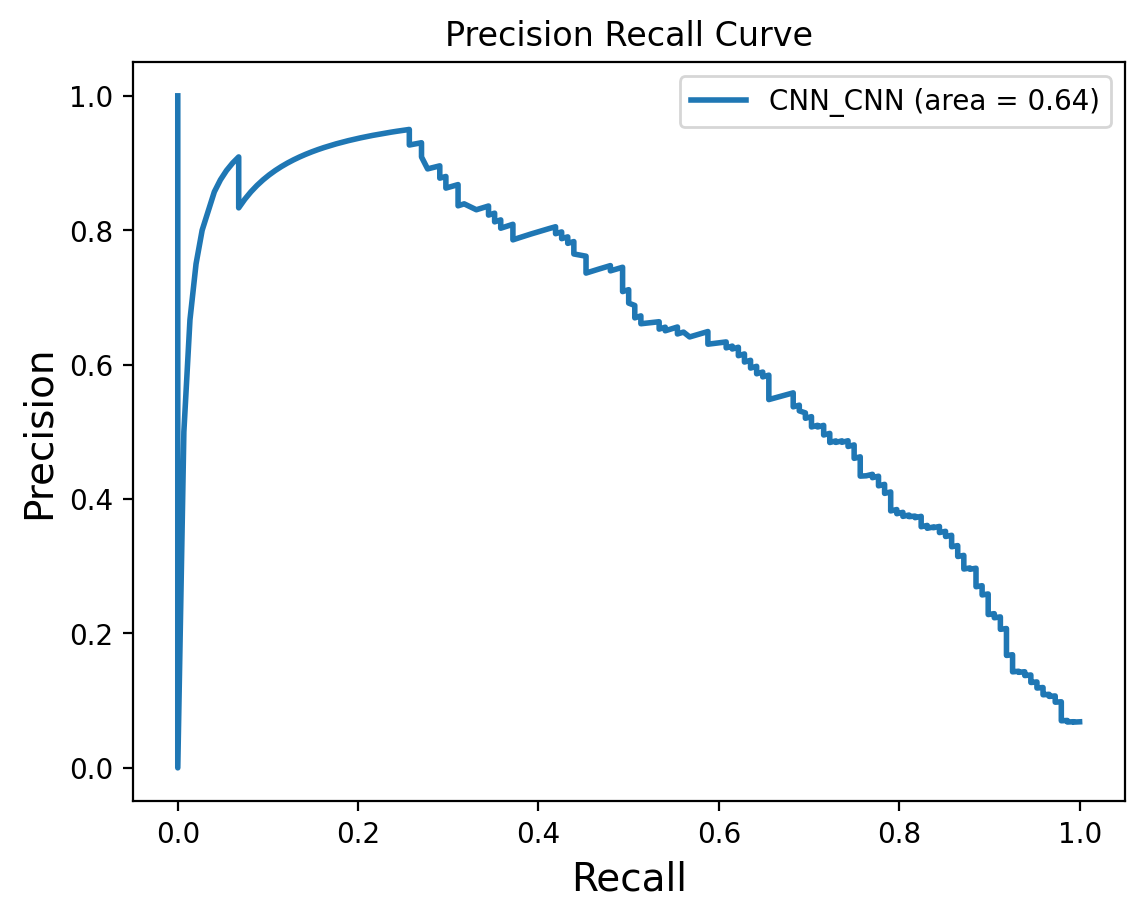

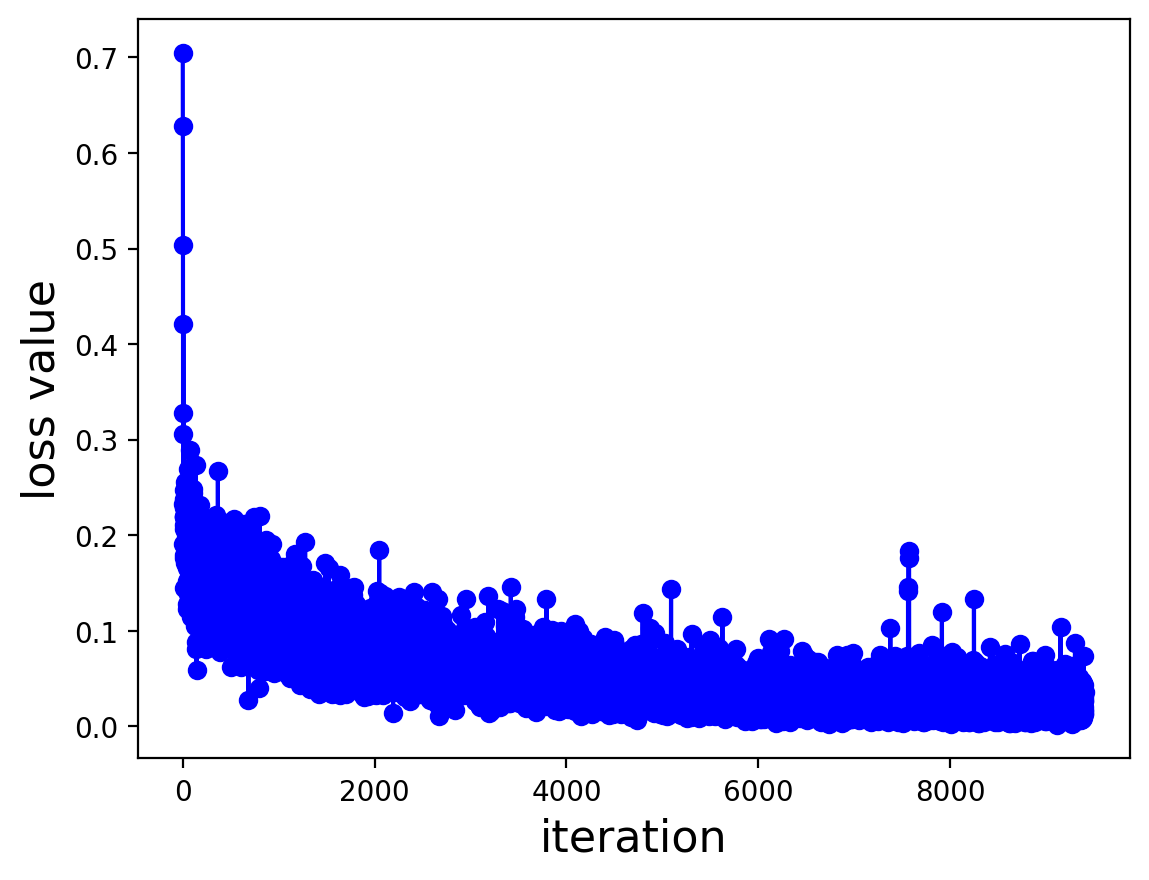

In [ ]:
# 시간이 오래 걸린다
# model.train(train, val, test)

# (참고) 약물 재창출

- drug repurposing
- 기존의 FDA허가 약물에 대해서 다른 질병(단백질)에 대한 효과를 예측
- DeepPurpose에서 제공하는 사전 학습된 DTI 모델을 사용한다
 - 다른 타겟 질병(단백질)과 기존의 허가 약물을 입력으로 넣어 상호작용을 예측

## 코로나 바이러스와 기존 약물의 결합을 예측

In [27]:
target, target_name = load_SARS_CoV_Protease_3CL() # SARS-CoV: 코로나바이러스
drug, drug_names = load_antiviral_drugs('./data', no_cid = True) # 항 바이러스 약물 데이터셋

### 데이터 확인

In [28]:
print('target_name :\t', target_name)
print('target :\t', target[:100], '...')
print('drug_names :\t', drug_names[:3], '...')
print('drug :\t\t', drug[:3], '...')

target_name :	 SARS-CoV 3CL Protease
target :	 SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKFSGDQWGDVLNLANNHEFEVVTQNGVTLNVVSRRLKGAVLILQTAVANAETPKYK ...
drug_names :	 ['Abacavir' 'Aciclovir' 'Adefovir'] ...
drug :		 ['C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO'
 'C1=NC2=C(N1COCCO)NC(=NC2=O)N' 'C1=NC(=C2C(=N1)N(C=N2)CCOCP(=O)(O)O)N'] ...


### 결합도 예측
- 사전학습 모델의 경로를 입력하지 않으면 DeepPurpose에서 제공하는 사전학습 모델이 사용됨

In [29]:
import DeepPurpose.oneliner as oneliner

oneliner.repurpose(*load_SARS_CoV2_Protease_3CL(), *load_antiviral_drugs(no_cid = True))

Save path not found or given and set to default: './save_folder/'. 
Loading customized repurposing dataset...
Beginning Downloading Pretrained Model...
Note: if you have already download the pretrained model before, please stop the program and set the input parameter 'pretrained_dir' to the path
pretrained model Successfully Downloaded...
Using pretrained model and making predictions...
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 1 with drug encoding MPNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 2 with drug encoding CNN and target encoding CNN are done...
-------------
rep

### 약물 이름의 index를 찾아 약물 데이터 확인

In [30]:
target_name = 'Fosamprenavir'
print('drug name : ', target_name)
print('drug index : ', np.where(drug_names == target_name)[0][0])
print('drug smiles : ', drug[31])

drug name :  Fosamprenavir
drug index :  31
drug smiles :  CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2CCOC2)OP(=O)(O)O)S(=O)(=O)C3=CC=C(C=C3)N


### COCONUT 데이터 상호작용 예측

In [5]:
with open("./real_coconut_smiles.pkl","rb") as f:
    coconut_smiles = np.array(pickle.load(f)).astype('object')
    
with open("./real_coconut_cid.pkl","rb") as f:
    coconut_cid = np.array(pickle.load(f)).astype('object')

In [11]:
len(coconut_smiles), 

(895068,)

In [17]:
with open("./real_coconut_smiles.pkl","rb") as f:
    coconut_smiles = np.array(pickle.load(f)).astype('object')
    
with open("./real_coconut_cid.pkl","rb") as f:
    coconut_cid = np.array(pickle.load(f)).astype('object')

print('cid_names :\t', coconut_cid[:3])
print('data :\t\t', coconut_smiles[:3])


cid_names :	 ['CNP0000002' 'CNP0000003' 'CNP0000003.1']
data :		 ['O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(OC(=O)C(N=CS)=CC)C(OC3OC(C)C(O)C(OC)C3)C2O'
 'O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C(=O)C5=C(OC)C=C4CC32C(O)C7=CC(=CC(OC)=C17)C'
 'CC1=CC(=C2C(=C1)[C@@H]([C@@]34CC5=C([C@H]4C=C[C@H]([C@H]3OC2=O)O)C6=C(C(=C5)OC)C(=O)C7=C(C(=CC=C7OC)OC)C6=O)O)OC']


In [12]:
oneliner.repurpose(target = target,
                    target_name = target_name,
                    X_repurpose = coconut_smiles[:10000],
                    drug_names = coconut_cid[:10000],
                    save_dir = './save_folder',
                    )

Loading customized repurposing dataset...
Beginning Downloading Pretrained Model...
Note: if you have already download the pretrained model before, please stop the program and set the input parameter 'pretrained_dir' to the path
Dataset already downloaded in the local system...
Using pretrained model and making predictions...
repurposing...
Drug Target Interaction Prediction Mode...
in total: 10000 drug-target pairs
encoding drug...
unique drugs: 10000
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 1 with drug encoding MPNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 10000 drug-target pairs
encoding drug...
unique drugs: 10000
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 2 with drug encoding CNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mod